In [28]:
# Import all important libraries 


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)

pd.set_option('display.max_rows',None)

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import logging
import pickle

In [29]:
store_data = pd.read_csv("cleaned_df_store.csv")
train_data = pd.read_csv("cleaned_df_train.csv")
test_data = pd.read_csv("cleaned_df_test.csv")

In [30]:
# Now we merge store data n train data 

df_train_store = pd.merge(train_data.reset_index(),store_data,how='inner',on ='Store')
df_train_store.info()

# Now we merge store data n test data 

df_test_store = pd.merge(test_data.reset_index(),store_data,how='inner',on ='Store')
df_test_store.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   index                      1017209 non-null  int64  
 1   Store                      1017209 non-null  int64  
 2   DayOfWeek                  1017209 non-null  int64  
 3   Date                       1017209 non-null  object 
 4   Sales                      1017209 non-null  float64
 5   Customers                  1017209 non-null  float64
 6   Open                       1017209 non-null  int64  
 7   Promo                      1017209 non-null  int64  
 8   StateHoliday               1017209 non-null  int64  
 9   SchoolHoliday              1017209 non-null  float64
 10  StoreType                  1017209 non-null  int64  
 11  Assortment                 1017209 non-null  int64  
 12  CompetitionDistance        1017209 non-null  float64
 13  CompetitionO

### Task 2.1 Preprocessing

we have a few datetime columns to preprocess. we can extract the following from them:
* weekdays
* weekends 
* number of days to holidays
* Number of days after holiday
* Beginning of month, mid month and ending of month


In [31]:
# convert date in datetimeindex format

df_train_store['Date'] = pd.DatetimeIndex(df_train_store['Date'])
df_train_store['Year'] = pd.DatetimeIndex(df_train_store['Date']).year
df_train_store['Month'] = pd.DatetimeIndex(df_train_store['Date']).month
df_train_store['Day'] = pd.DatetimeIndex(df_train_store['Date']).day
df_train_store['WeekOfYear'] = df_train_store['Date'].dt.weekofyear

# convert date in datetimeindex format

df_test_store['Date'] = pd.DatetimeIndex(df_test_store['Date'])
df_test_store['Year'] = pd.DatetimeIndex(df_test_store['Date']).year
df_test_store['Month'] = pd.DatetimeIndex(df_test_store['Date']).month
df_test_store['Day'] = pd.DatetimeIndex(df_test_store['Date']).day
df_test_store['WeekOfYear'] = df_test_store['Date'].dt.weekofyear

In [32]:
# Extract weekdays and weekends

df_train_store['Weekday'] = df_train_store['Date'].dt.weekday
df_train_store['Weekend'] = df_train_store['Weekday'].isin([5, 6]).astype(int)

# Extract weekdays and weekends

df_test_store['Weekday'] = df_test_store['Date'].dt.weekday
df_test_store['Weekend'] = df_test_store['Weekday'].isin([5, 6]).astype(int)


In [33]:
# Create a column for 'number of days to holidays'
df_train_store['DaysToHoliday'] = df_train_store['Date'].sub(df_train_store['Date'].shift(-1))

# Create a column for 'number of days after holidays'
df_train_store['DaysAfterHoliday'] = df_train_store['Date'].sub(df_train_store['Date'].shift(1))

# Convert the timedelta columns to integers representing the number of days
df_train_store['DaysToHoliday'] = df_train_store['DaysToHoliday'].dt.days
df_train_store['DaysAfterHoliday'] = df_train_store['DaysAfterHoliday'].dt.days



In [34]:
# Extract beginning, mid, and ending of the month

df_train_store['BeginningOfMonth'] = (df_train_store['Date'].dt.day <= 10).astype(int)
df_train_store['MidMonth'] = ((df_train_store['Date'].dt.day > 10) & (df_train_store['Date'].dt.day <= 20)).astype(int)
df_train_store['EndOfMonth'] = (df_train_store['Date'].dt.day > 20).astype(int)


In [35]:
# Example: Calculate the quarter of the year
df_train_store['Quarter'] = df_train_store['Date'].dt.quarter

In [36]:
# # Scaling the data using StandardScaler
# scaler = StandardScaler()
# scaled_features = ['DaysToHoliday1', 'DaysToHoliday2', 'DaysAfterHoliday1', 'DaysAfterHoliday1', 'Weekday', 'Quarter']
# df_train_store[scaled_features] = scaler.fit_transform(df_train_store[scaled_features])

In [37]:
df_train_store.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Year,Month,Day,WeekOfYear,Weekday,Weekend,DaysToHoliday,DaysAfterHoliday,BeginningOfMonth,MidMonth,EndOfMonth,Quarter
0,0,1,5,2015-07-31,5263.0,555.0,1,1,0,0.0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,7,31,31,4,0,1.0,NaN,0,0,1,3
1,1115,1,4,2015-07-30,5020.0,546.0,1,1,0,0.0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,7,30,31,3,0,1.0,-1.0,0,0,1,3
2,2230,1,3,2015-07-29,4782.0,523.0,1,1,0,0.0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,7,29,31,2,0,1.0,-1.0,0,0,1,3
3,3345,1,2,2015-07-28,5011.0,560.0,1,1,0,0.0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,7,28,31,1,0,1.0,-1.0,0,0,1,3
4,4460,1,1,2015-07-27,6102.0,612.0,1,1,0,0.0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,7,27,31,0,0,1.0,-1.0,0,0,1,3


In [38]:
df_test_store.head()

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Year,Month,Day,WeekOfYear,Weekday,Weekend
0,0,1,1,4,2015-09-17,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,9,17,38,3,0
1,856,857,1,3,2015-09-16,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,9,16,38,2,0
2,1712,1713,1,2,2015-09-15,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,9,15,38,1,0
3,2568,2569,1,1,2015-09-14,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,9,14,38,0,0
4,3424,3425,1,7,2015-09-13,0.0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,2015,9,13,37,6,1


###  Task 2.2 - Building models with sklearn pipelines

In [39]:
# columns to be use:['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']

# Selecting columns for the features and labels in the training dataset
columns = ['Sales','Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']


# Selecting only the feature columns (excluding 'Sales') for further analysis
feature_columns = ['Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

# Defining the sample size for visualization purposes
sample_size = 1000

# Creating a sample of the training dataset for visualization
sampled_df = df_train_store[columns].sample(sample_size)


# Separating the features and labels for the training dataset
train_x= sampled_df[feature_columns] # Features
train_y = sampled_df[['Sales']]   # Labels (Sales)


In [40]:
# Creating MinMaxScaler objects for feature and label scaling

x_scaler = MinMaxScaler() # For features
y_scaler = MinMaxScaler() # For labels

#  Scaling the feature columns using MinMaxScaler
# X = x_scaler.fit_transform(train_x)
X = train_x

# Scaling the label column ('Sales') using MinMaxScaler
Y = y_scaler.fit_transform(train_y)

In [41]:

# Splitting the dataset into training and testing sets
#'X' represents the features, and 'Y' represents the labels.
# The 'test_size=0.2' parameter specifies that 20% of the data will be used for testing.


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [42]:
# Creating a Random Forest Regressor with specified parameters
#  Convert datetime columns to numeric representation
# X_train['Date'] = X_train['Date'].astype(int)
# X_test['Date'] = X_test['Date'].astype(int)

# 'random_state' is set for reproducibility of results.
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=25, random_state=0)

# Training the Random Forest Regressor using the training data
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, random_state=0)

In [43]:
# Evaluating the model's prediction score on the test set

score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 58.4%


In [44]:
# Preparing the train and test features:

# Assigning features and labels to 'x' and 'y' variables
x = train_x
y = train_y

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

In [45]:
# Set Pipe Lines:


#  Creating a pipeline for Random Forest Regressor
rfr = Pipeline(steps=[
    ('scaler1', MinMaxScaler()),
    ('rfr_regretion', RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0))
])

#  Creating a pipeline for Linear Regression
lr = Pipeline(steps=[
    ('scaler2', MinMaxScaler()),
    ('lr_regretion', LinearRegression())
])
# Creating a pipeline for Decision Tree Regressor
dt = Pipeline(steps=[
    ('scaler3', MinMaxScaler()),
    ('dt_regretion', DecisionTreeRegressor(random_state = 0)  )
])

In [46]:
# Fitting the Random Forest Regressor to the training data
rfr.fit(X_train, y_train)

# Fitting the Linear Regression model to the training data
lr.fit(X_train, y_train)

# Fitting the Decision Tree Regressor to the training data
dt.fit(X_train, y_train)

Pipeline(steps=[('scaler3', MinMaxScaler()),
                ('dt_regretion', DecisionTreeRegressor(random_state=0))])

Prediction Score of the RandomForestRegressor is 59.2%
Prediction Score of the LinearRegression is 58.08%
Prediction Score of the DecisionTreeRegressor is 17.22%


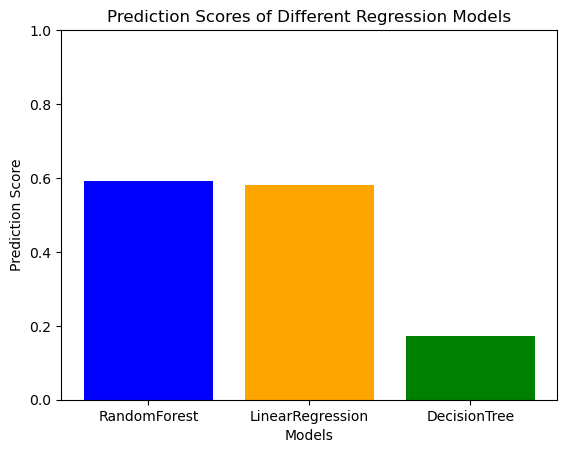

In [47]:
# Evaluating the prediction scores of different regression models on the test set
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

# score()' computes the coefficient of determination (R^2) for each model's predictions on the test set.

# Displaying the prediction scores for each model
print(f"Prediction Score of the RandomForestRegressor is {round(rfr_score * 100, 2)}%")
print(f"Prediction Score of the LinearRegression is {round(lr_score * 100, 2)}%")
print(f"Prediction Score of the DecisionTreeRegressor is {round(dt_score * 100, 2)}%")

# Plotting a bar chart to compare prediction scores of different models
models = ['RandomForest', 'LinearRegression', 'DecisionTree']
scores = [rfr_score, lr_score, dt_score]

plt.bar(models, scores, color=['blue', 'orange', 'green'])
plt.title('Prediction Scores of Different Regression Models')
plt.xlabel('Models')
plt.ylabel('Prediction Score')
plt.ylim(0, 1)  # Adjust the y-axis range if needed

#The bar chart visually compares the prediction scores of different regression models.
plt.show()


### Task 2.3- Choose a loss function

RandomForest Root Mean Square Error: 2063.051539167415
Linear Regression Root Mean Square Error: 2091.0359907430634
Decision Tree Root Mean Square Error: 2938.5006040496232


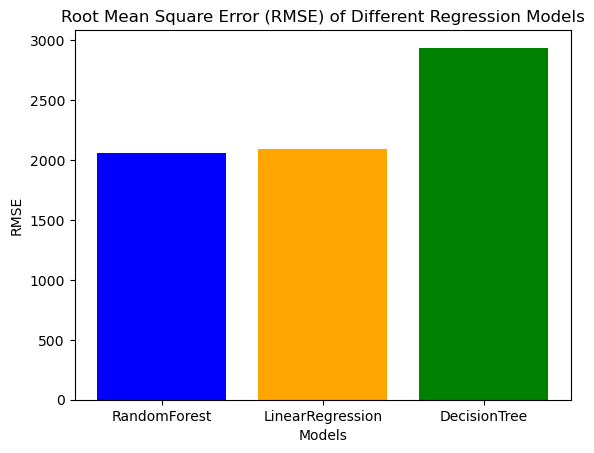

In [48]:
# Making predictions using the trained models on the test set
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

# Calculate RMSE for each model
rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_prediction))
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_prediction))
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_prediction))

# Print RMSE for each model
print(f"RandomForest Root Mean Square Error: {rfr_rmse}")
print(f"Linear Regression Root Mean Square Error: {lr_rmse}")
print(f"Decision Tree Root Mean Square Error: {dt_rmse}")

# RMSE measures the average magnitude of the errors between predicted and true values.
# Lower RMSE values indicate better model performance.

# Plotting a bar chart to compare RMSE values of different models
models = ['RandomForest', 'LinearRegression', 'DecisionTree']
rmse_values = [rfr_rmse, lr_rmse, dt_rmse]

plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('Root Mean Square Error (RMSE) of Different Regression Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

#The bar chart visually compares the RMSE values of different regression models.


### Task 2.4 -  Post Prediction analysis

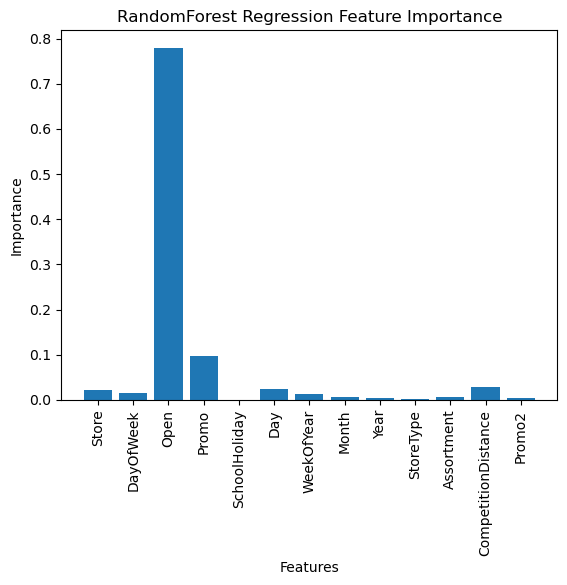

In [49]:
# Extracting feature importance from the trained RandomForest Regressor
feature_importance = rfr[1].feature_importances_

# Plotting feature importance
plt.bar(feature_columns, feature_importance)
plt.title('RandomForest Regression Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.show()

# 'rfr[1]' accesses the trained RandomForest Regressor within the pipeline.
# 'feature_importance' contains the importance scores of each feature in the model.
# The bar chart visually represents the importance of each feature in predicting the target variable.


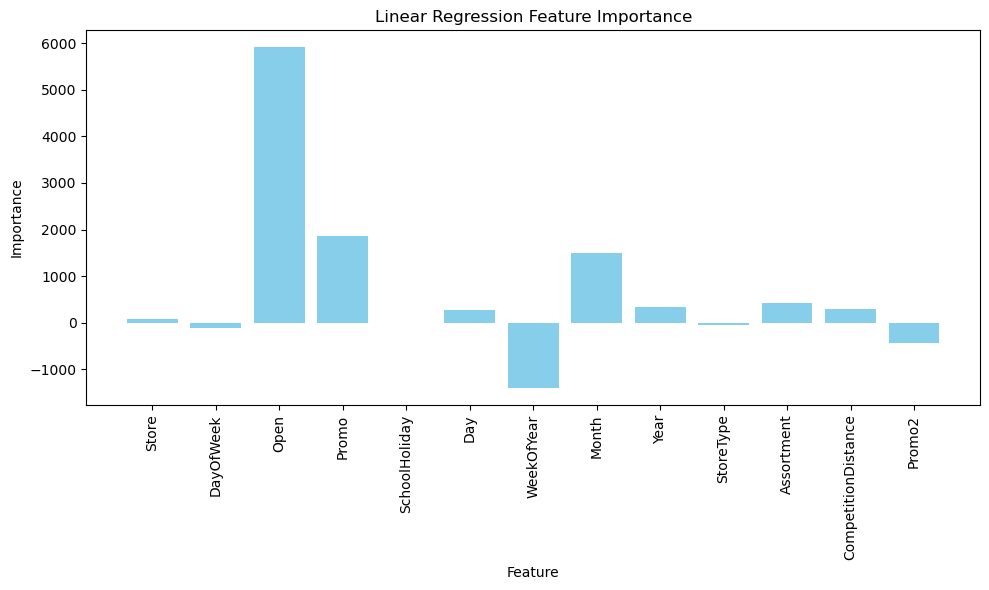

In [50]:
# Extracting coefficients (importance) from the trained Linear Regression model
important_features = lr[1].coef_[0]

# Plotting feature importance for Linear Regression
plt.figure(figsize=(10, 6))
plt.bar(feature_columns, list(important_features), color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Linear Regression Feature Importance')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.tight_layout()
plt.show()

#'lr[1]' accesses the trained Linear Regression model within the pipeline.
#'important_features' contains the coefficients of each feature in the linear regression equation.
# The bar chart visually represents the importance of each feature in predicting the target variable in a linear regression context.


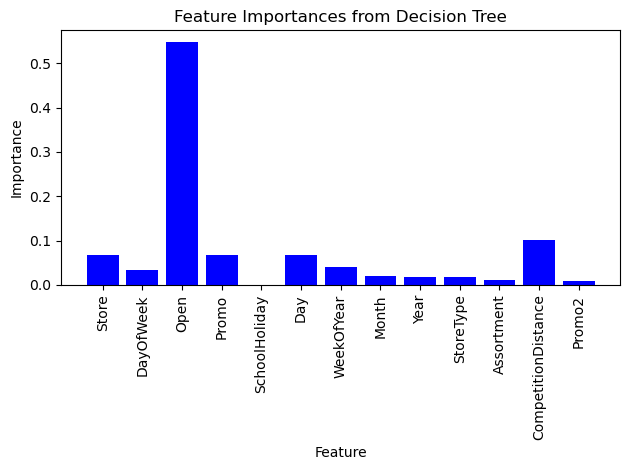

In [51]:

# Extracting feature importance from the trained Decision Tree model
important_features = dt[1].feature_importances_

# Plotting feature importance for Decision Tree
plt.bar(feature_columns, important_features, color='blue')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.tight_layout()
plt.show()

# 'dt[1]' accesses the trained Decision Tree model within the pipeline.
# 'important_features' contains the importance scores of each feature in the decision tree model.
# The bar chart visually represents the importance of each feature in making splits and predictions in the decision tree.


### Task 2.5 -  Serialize models

In [52]:
import pickle # Read and Save model - Serialization
from datetime import datetime
import os


In [53]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
models_directory = 'models'
rfr_model_file_name = f'models/rfr-{time}.pkl'
lr_model_file_name = f'models/lr-{time}.pkl'
dt_model_file_name = f'models/dt-{time}.pkl'

files = [rfr_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]


os.makedirs(models_directory,exist_ok = True)

print(rfr_model_file_name)
print(lr_model_file_name)
print(dt_model_file_name)


for i in range(len(files)):
    pickle.dump(models[i], open(files[i], 'wb'))


models/rfr-2024-01-05-08-32-38.pkl
models/lr-2024-01-05-08-32-38.pkl
models/dt-2024-01-05-08-32-38.pkl


In [54]:
rfr_file = 'models/rfr-2023-12-23-10-09-41.pkl'
lr_file = 'models/lr-2023-12-23-10-09-41.pkl'
dt_file = 'models/dt-2023-12-23-10-09-41.pkl'

rfr_model = pickle.load(open(rfr_file,'rb'))
lr_model = pickle.load(open(lr_file, 'rb'))
dt_model = pickle.load(open(dt_file,'rb'))

### Task 2.7- Using MLFlow to serve the prediction

In [44]:
pip install mlflow

     --------------------------------------- 19.1/19.1 MB 10.4 MB/s eta 0:00:00
     --------------------------------------- 24.6/24.6 MB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 57.7/57.7 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 41.2/41.2 kB 967.0 kB/s eta 0:00:00
  Using cached GitPython-3.1.40-py3-none-any.whl (190 kB)
     -------------------------------------- 148.1/148.1 kB 4.4 MB/s eta 0:00:00
     -------------------------------------- 150.3/150.3 kB 4.5 MB/s eta 0:00:00
     -------------------------------------- 233.4/233.4 kB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 78.6/78.6 kB 4.3 MB/s eta 0:00:00
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [28]:
import mlflow
import mlflow.sklearn

In [29]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if(model_type == 'RandomForest'):
        model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
    
        
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested = True):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if(model_type == 'LinearRegression'):
                mlflow.log_param('LR-Score', score)
                
            if(model_type == 'RandomForest'):
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type +' Model')
            mlflow.end_run()
            
    print()

## Running this code will create multiple mflow models 
## Create a branch before running this file

# train_model(X, Y, "RandomForest")
# train_model(X, Y)